In [4]:
!pip install numpyro pymc3 numpy pandas matplotlib seaborn arviz theano scipy

     |████████████████████████████████| 225kB 5.0MB/s 
     |████████████████████████████████| 2.8MB 8.3MB/s 
     |████████████████████████████████| 35.7MB 90kB/s 
     |████████████████████████████████| 593kB 28.2MB/s 
  Created wheel for theano: filename=Theano-1.0.5-cp37-none-any.whl size=2668111 sha256=1108271e9d622c6d78f160c827b535f9da78379faaa787bd856522a1b2194714
  Stored in directory: /root/.cache/pip/wheels/89/40/74/3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c
  Created wheel for jax: filename=jax-0.2.10-cp37-none-any.whl size=679776 sha256=a4e4789d934bee2c8b1fe8ccfcc22b13d5c328fd05dfd4ad6770a333abe78661
  Stored in directory: /root/.cache/pip/wheels/44/ea/ac/3be3bc19ee3b62f6fe1561eb6df1199284bb6bab819c1befa4
Successfully built theano jax
  Found existing installation: jaxlib 0.1.66+cuda110
    Uninstalling jaxlib-0.1.66+cuda110:
      Successfully uninstalled jaxlib-0.1.66+cuda110
  Found existing installation: jax 0.2.13
    Uninstalling jax-0.2.13:
      Successfully

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats

In [7]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [8]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

Вспомним формулу Байеса:
$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}
$$

Простой дискретный пример.

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася.

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.

Ответ: $\hat{p}_{c} = 4/10$

б) Сделаем то же самое в рамках байесовского подхода. 

$$ 
p(\theta | y)  \propto p(y| \theta) \times p(\theta)
$$

$ p(\theta) = 1/2 $ (оба значения доли карасей равновероятны), $ p(y| \theta) = p^x \times (1-p)^{n-x}$. Посчитаем апостериорное распределение для обоих возможных значений $p$: 

In [16]:
p1 = (1/3) ** 4 * (2/3) ** 6 * (1/2)
p2 = (2/3) ** 4 * (1/3) ** 6 * (1/2)
print(f"Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет {p1/(p1+p2)}.")
print(f"Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет {p2/(p1+p2)}.")

Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет 0.8.
Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет 0.2.


Это вполне логично - 0.4 ближе к 1/3, чем к 2/3. 

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [17]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.29


array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

1. Задайте вероятностную модель.

In [18]:
def model(y):
  p = numpyro.sample('share', dist.Uniform(0, 1))
  y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs=y)

2. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [26]:
kernel = NUTS(model) # NUTS sampler 
# 100 первых наблюдений будет выкинуто при оценке апостериорного распределения
# оставшиеся 500 наблюдений будут сохранены
mcmc = MCMC(kernel, 100, 1000)
mcmc.run(random.PRNGKey(0), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:04<00:00, 255.72it/s, 3 steps of size 1.12e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.30      0.04      0.29      0.23      0.37    289.07      1.00

Number of divergences: 0


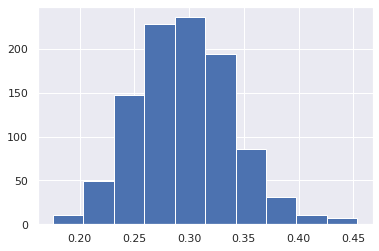

In [27]:
plt.hist(samples_1['share']);